# A04a: Filter Fundamentals (Quick Version)

**Duration**: ~30 minutes  
**Prerequisites**: A01 (Signals and Sampling), A02 (Frequency Domain), A03 (Power Spectrum)

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/filtering.py` instead of defining them inline. For the full tutorial with step-by-step function implementations, see [A04a_filter_fundamentals.ipynb](A04a_filter_fundamentals.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the four fundamental filter types (lowpass, highpass, bandpass, notch)
- Distinguish between FIR and IIR filter architectures
- Explain key filter characteristics (cutoff frequency, transition band, filter order)
- Use the filter design functions from `src/filtering.py`

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Filter Types](#section-2-filter-types)
3. [Filter Characteristics](#section-3-filter-characteristics)
4. [FIR vs IIR Filters](#section-4-fir-vs-iir-filters)
5. [Filter Design Functions](#section-5-filter-design-functions)
6. [Comparing IIR Filter Types](#section-6-comparing-iir-filter-types)
7. [Exercises](#section-7-exercises)
8. [Summary](#summary)
9. [External Resources](#external-resources)
10. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS
from src.filtering import design_iir_filter, design_fir_filter
from src.signals import generate_time_vector, generate_sine_wave

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials


## Section 1: Introduction

Digital filters are essential tools in EEG signal processing. They allow us to selectively pass or attenuate specific frequency components, enabling us to isolate brain rhythms of interest, remove noise, and prepare signals for connectivity analysis.

In hyperscanning studies, proper filtering is crucial because connectivity metrics are sensitive to artifacts and noise. A poorly filtered signal can create spurious correlations between participants, while over-filtering can remove the very neural activity we want to study.

This notebook focuses on the **fundamentals of filter design**: understanding filter types, their frequency responses, and the trade-offs between different filter architectures. We will use the functions from `src/filtering.py` to design and visualize filters.

## Section 2: Filter Types

There are four fundamental filter types, each defined by which frequencies they pass and which they attenuate:

- **Lowpass**: Passes frequencies below a cutoff, attenuates higher frequencies
- **Highpass**: Passes frequencies above a cutoff, attenuates lower frequencies  
- **Bandpass**: Passes frequencies within a range, attenuates frequencies outside
- **Notch (Band-stop)**: Attenuates a narrow frequency range, passes everything else

Each filter type serves specific purposes in EEG preprocessing:
- Lowpass filters remove high-frequency noise (muscle artifacts, line noise)
- Highpass filters remove slow drifts (electrode drift, movement artifacts)
- Bandpass filters isolate specific frequency bands (alpha, theta, etc.)
- Notch filters remove powerline interference (50 Hz or 60 Hz)

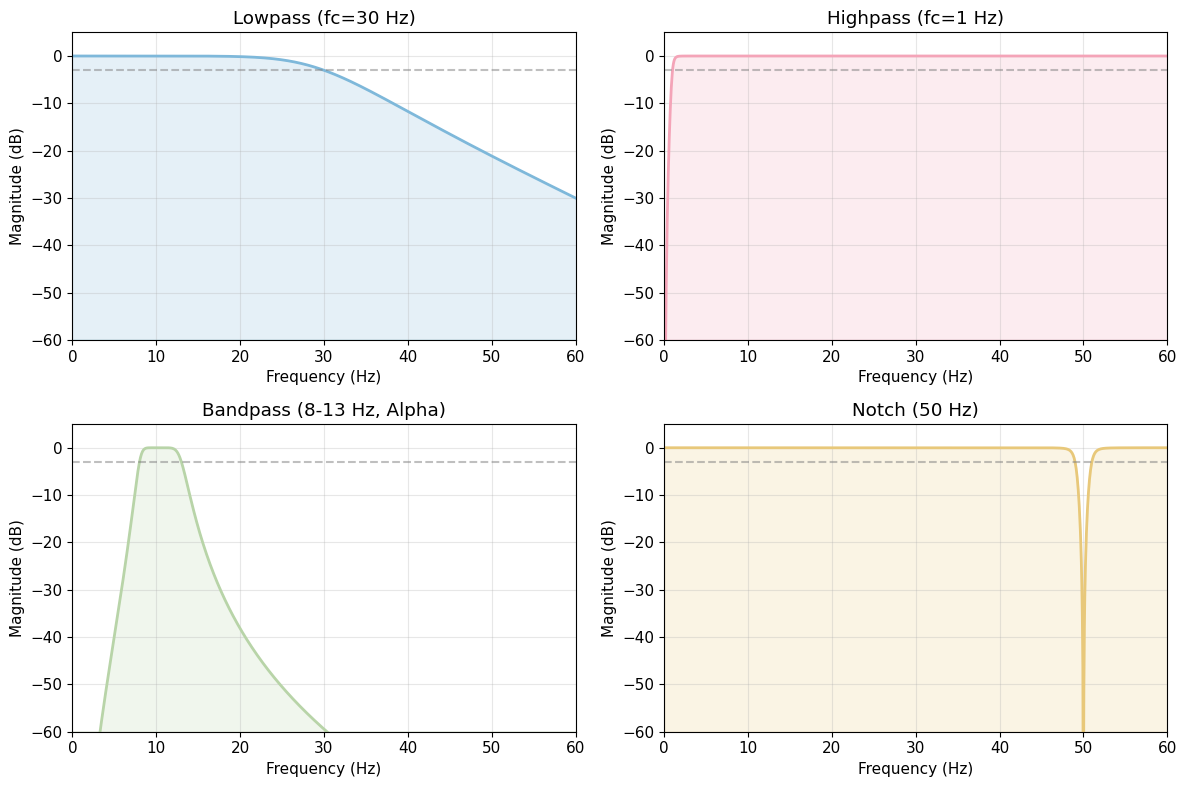

In [2]:
# =============================================================================
# Section 2: Filter Types Visualization
# =============================================================================

fs = 250  # Sampling frequency (Hz)

# Design the four filter types
b_low, a_low = design_iir_filter(cutoff=30, fs=fs, order=4, btype='low')
b_high, a_high = design_iir_filter(cutoff=1, fs=fs, order=4, btype='high')
b_band, a_band = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype='band')
b_notch, a_notch = design_iir_filter(cutoff=(49, 51), fs=fs, order=2, btype='bandstop')

# Compute frequency responses
w_low, h_low = freqz(b_low, a_low, worN=2048, fs=fs)
w_high, h_high = freqz(b_high, a_high, worN=2048, fs=fs)
w_band, h_band = freqz(b_band, a_band, worN=2048, fs=fs)
w_notch, h_notch = freqz(b_notch, a_notch, worN=2048, fs=fs)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

filters = [
    (w_low, h_low, "Lowpass (fc=30 Hz)", COLORS["signal_1"]),
    (w_high, h_high, "Highpass (fc=1 Hz)", COLORS["signal_2"]),
    (w_band, h_band, "Bandpass (8-13 Hz, Alpha)", COLORS["signal_3"]),
    (w_notch, h_notch, "Notch (50 Hz)", COLORS["signal_4"]),
]

for ax, (w, h, title, color) in zip(axes.flat, filters):
    magnitude_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax.plot(w, magnitude_db, color=color, linewidth=2)
    ax.axhline(-3, color="gray", linestyle="--", alpha=0.5, label="-3 dB")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude (dB)")
    ax.set_title(title)
    ax.set_xlim(0, 60)
    ax.set_ylim(-60, 5)
    ax.grid(True, alpha=0.3)
    ax.fill_between(w, -60, magnitude_db, alpha=0.2, color=color)

plt.tight_layout()
plt.show()

## Section 3: Filter Characteristics

Every filter is characterized by several key properties:

- **Cutoff frequency (fc)**: The frequency at which the filter response drops by 3 dB (half power)
- **Passband**: The range of frequencies that pass through with minimal attenuation
- **Stopband**: The range of frequencies that are significantly attenuated
- **Transition band**: The region between passband and stopband where attenuation increases
- **Filter order**: Determines the steepness of the transition (higher order = sharper cutoff)

The **-3 dB point** is the standard definition of cutoff frequency because at this point, the signal power is reduced by half (and amplitude by approximately 70.7%).

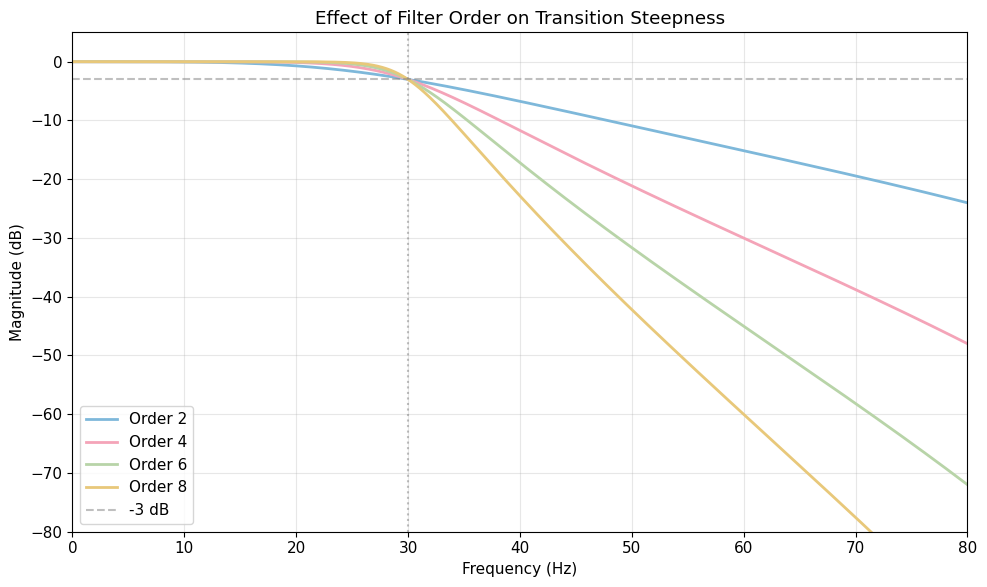

Higher order = sharper transition, but more computational cost and potential instability.


In [3]:
# =============================================================================
# Section 3: Effect of Filter Order
# =============================================================================

fs = 250
cutoff = 30
orders = [2, 4, 6, 8]
colors = [COLORS["signal_1"], COLORS["signal_2"], COLORS["signal_3"], COLORS["signal_4"]]

fig, ax = plt.subplots(figsize=(10, 6))

for order, color in zip(orders, colors):
    b, a = design_iir_filter(cutoff=cutoff, fs=fs, order=order, btype='low')
    w, h = freqz(b, a, worN=2048, fs=fs)
    magnitude_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax.plot(w, magnitude_db, color=color, linewidth=2, label=f"Order {order}")

ax.axhline(-3, color="gray", linestyle="--", alpha=0.5, label="-3 dB")
ax.axvline(cutoff, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (dB)")
ax.set_title("Effect of Filter Order on Transition Steepness")
ax.set_xlim(0, 80)
ax.set_ylim(-80, 5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Higher order = sharper transition, but more computational cost and potential instability.")

## Section 4: FIR vs IIR Filters

Digital filters come in two fundamental architectures:

**FIR (Finite Impulse Response)**:
- Output depends only on current and past inputs
- Always stable
- Can have exactly linear phase (no waveform distortion)
- Requires more coefficients for sharp transitions

**IIR (Infinite Impulse Response)**:
- Output depends on inputs AND past outputs (feedback)
- Can be unstable if poorly designed
- Non-linear phase (distorts waveform shape)
- Achieves sharp transitions with fewer coefficients

For EEG processing, the key consideration is **phase distortion**. IIR filters shift different frequencies by different amounts, which can distort the temporal relationships in the signal.

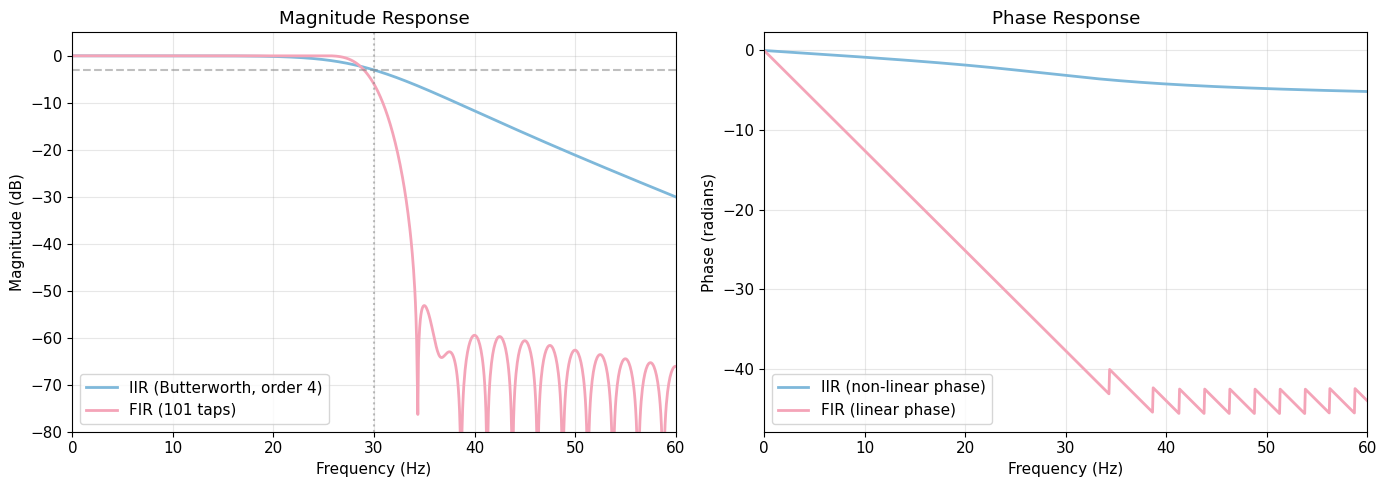

Coefficient comparison:
   IIR: 5 + 5 = 10 coefficients
   FIR: 101 coefficients


In [4]:
# =============================================================================
# Section 4: FIR vs IIR Comparison
# =============================================================================

fs = 250
cutoff = 30

# Design both filter types
b_iir, a_iir = design_iir_filter(cutoff=cutoff, fs=fs, order=4, btype='low')
h_fir = design_fir_filter(cutoff=cutoff, fs=fs, numtaps=101, btype='low')

# Compute frequency responses
w_iir, H_iir = freqz(b_iir, a_iir, worN=2048, fs=fs)
w_fir, H_fir = freqz(h_fir, worN=2048, fs=fs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Magnitude comparison
axes[0].plot(w_iir, 20 * np.log10(np.abs(H_iir) + 1e-10), 
             color=COLORS["signal_1"], linewidth=2, label="IIR (Butterworth, order 4)")
axes[0].plot(w_fir, 20 * np.log10(np.abs(H_fir) + 1e-10), 
             color=COLORS["signal_2"], linewidth=2, label="FIR (101 taps)")
axes[0].axhline(-3, color="gray", linestyle="--", alpha=0.5)
axes[0].axvline(cutoff, color="gray", linestyle=":", alpha=0.5)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Magnitude (dB)")
axes[0].set_title("Magnitude Response")
axes[0].set_xlim(0, 60)
axes[0].set_ylim(-80, 5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Phase comparison
axes[1].plot(w_iir, np.unwrap(np.angle(H_iir)), 
             color=COLORS["signal_1"], linewidth=2, label="IIR (non-linear phase)")
axes[1].plot(w_fir, np.unwrap(np.angle(H_fir)), 
             color=COLORS["signal_2"], linewidth=2, label="FIR (linear phase)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Phase (radians)")
axes[1].set_title("Phase Response")
axes[1].set_xlim(0, 60)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Coefficient comparison:")
print(f"   IIR: {len(b_iir)} + {len(a_iir)} = {len(b_iir) + len(a_iir)} coefficients")
print(f"   FIR: {len(h_fir)} coefficients")

## Section 5: Filter Design Functions

The `src/filtering.py` module provides two main design functions:

**`design_iir_filter()`** - Design an IIR filter
- `cutoff`: Cutoff frequency in Hz (or tuple for bandpass)
- `fs`: Sampling frequency
- `order`: Filter order (higher = sharper transition)
- `btype`: 'low', 'high', 'band', 'bandstop'
- `ftype`: 'butter', 'cheby1', 'cheby2', 'ellip'

**`design_fir_filter()`** - Design a FIR filter
- `cutoff`: Cutoff frequency in Hz (or tuple for bandpass)
- `fs`: Sampling frequency
- `numtaps`: Number of coefficients (should be odd)
- `btype`: 'low', 'high', 'band', 'bandstop'
- `window`: Window function ('hamming', 'hann', 'blackman')

In [5]:
# =============================================================================
# Section 5: Filter Design Examples
# =============================================================================

fs = 250  # Hz

print("Filter Design Examples:")
print("=" * 50)

# Lowpass to remove high-frequency noise
b_lp, a_lp = design_iir_filter(cutoff=40, fs=fs, order=4, btype='low')
print(f"\n1. Lowpass 40 Hz (remove muscle artifacts):")
print(f"   IIR Butterworth order 4")
print(f"   Coefficients: b={len(b_lp)}, a={len(a_lp)}")

# Highpass to remove slow drifts
b_hp, a_hp = design_iir_filter(cutoff=0.5, fs=fs, order=4, btype='high')
print(f"\n2. Highpass 0.5 Hz (remove electrode drift):")
print(f"   IIR Butterworth order 4")
print(f"   Coefficients: b={len(b_hp)}, a={len(a_hp)}")

# Bandpass for alpha band
b_alpha, a_alpha = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype='band')
print(f"\n3. Bandpass 8-13 Hz (alpha band):")
print(f"   IIR Butterworth order 4")
print(f"   Coefficients: b={len(b_alpha)}, a={len(a_alpha)}")

# FIR bandpass for better phase properties
h_alpha_fir = design_fir_filter(cutoff=(8, 13), fs=fs, numtaps=201, btype='band')
print(f"\n4. Bandpass 8-13 Hz (FIR, linear phase):")
print(f"   FIR with 201 taps (Hamming window)")
print(f"   Coefficients: {len(h_alpha_fir)}")

Filter Design Examples:

1. Lowpass 40 Hz (remove muscle artifacts):
   IIR Butterworth order 4
   Coefficients: b=5, a=5

2. Highpass 0.5 Hz (remove electrode drift):
   IIR Butterworth order 4
   Coefficients: b=5, a=5

3. Bandpass 8-13 Hz (alpha band):
   IIR Butterworth order 4
   Coefficients: b=9, a=9

4. Bandpass 8-13 Hz (FIR, linear phase):
   FIR with 201 taps (Hamming window)
   Coefficients: 201


## Section 6: Comparing IIR Filter Types

The `design_iir_filter()` function supports four IIR filter families:

- **Butterworth**: Maximally flat passband, smooth transition, most commonly used
- **Chebyshev Type 1**: Steeper transition, ripples in passband
- **Chebyshev Type 2**: Steeper transition, ripples in stopband
- **Elliptic**: Sharpest transition, ripples in both passband and stopband

For EEG processing, **Butterworth** is typically preferred because the flat passband preserves relative amplitudes across frequencies.

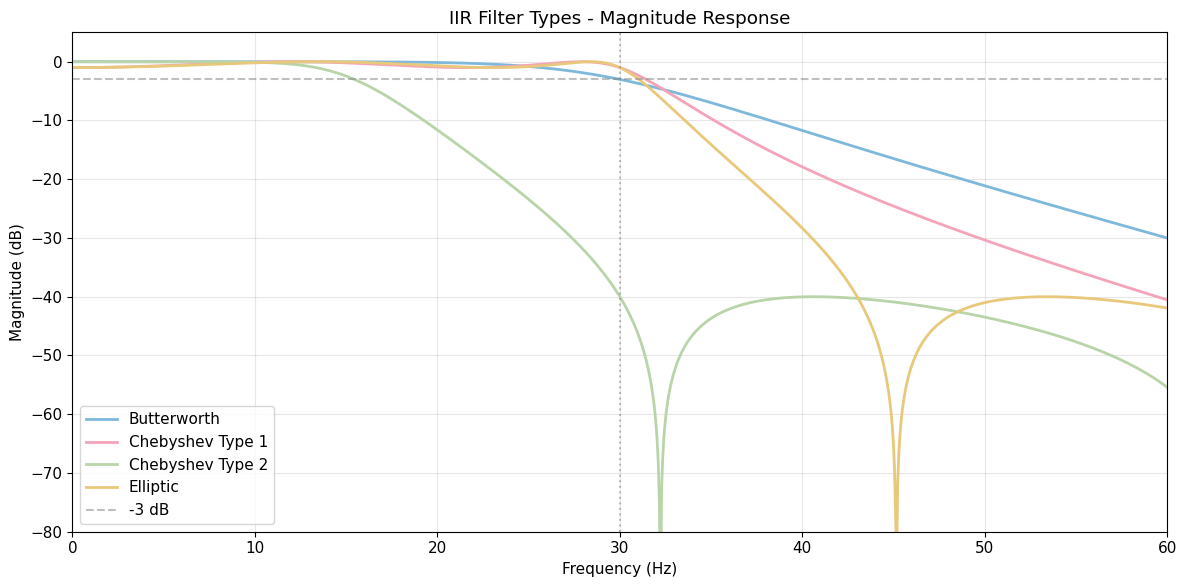


Observations:
   Butterworth: Smooth, flat passband (best for EEG)
   Chebyshev Type 1: Ripples visible in passband
   Chebyshev Type 2: Ripples in stopband, flat passband
   Elliptic: Sharpest transition but ripples everywhere


In [6]:
# =============================================================================
# Section 6: IIR Filter Type Comparison
# =============================================================================

fs = 250
cutoff = 30
order = 4

filter_types = ['butter', 'cheby1', 'cheby2', 'ellip']
colors = [COLORS['signal_1'], COLORS['signal_2'], COLORS['signal_3'], COLORS['signal_4']]
labels = ['Butterworth', 'Chebyshev Type 1', 'Chebyshev Type 2', 'Elliptic']

fig, ax = plt.subplots(figsize=(12, 6))

for ftype, color, label in zip(filter_types, colors, labels):
    b, a = design_iir_filter(cutoff=cutoff, fs=fs, order=order, btype='low', ftype=ftype)
    w, h = freqz(b, a, worN=2048, fs=fs)
    ax.plot(w, 20 * np.log10(np.abs(h) + 1e-10), color=color, linewidth=2, label=label)

ax.axhline(-3, color='gray', linestyle='--', alpha=0.5, label='-3 dB')
ax.axvline(cutoff, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('IIR Filter Types - Magnitude Response')
ax.set_xlim(0, 60)
ax.set_ylim(-80, 5)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("   Butterworth: Smooth, flat passband (best for EEG)")
print("   Chebyshev Type 1: Ripples visible in passband")
print("   Chebyshev Type 2: Ripples in stopband, flat passband")
print("   Elliptic: Sharpest transition but ripples everywhere")

## Section 7: Exercises

### Exercise 1: Design an Alpha Band Filter

Design both IIR and FIR bandpass filters for the alpha band (8-13 Hz) and compare their frequency responses.

In [7]:
# =============================================================================
# Exercise 1: Alpha Band Filter
# =============================================================================

# TODO: Uncomment and complete
# fs = 250
# 
# # Design IIR bandpass for alpha
# b_alpha_iir, a_alpha_iir = design_iir_filter(...)
# 
# # Design FIR bandpass for alpha
# h_alpha_fir = design_fir_filter(...)
# 
# # Plot and compare frequency responses
# ...

### Exercise 2: Effect of Filter Order

Design lowpass filters with orders 2, 4, 6, and 8. How does the order affect the transition band width?

In [8]:
# =============================================================================
# Exercise 2: Filter Order Effect
# =============================================================================

# TODO: Uncomment and complete
# fs = 250
# cutoff = 30
# orders = [2, 4, 6, 8]
# 
# for order in orders:
#     b, a = design_iir_filter(cutoff=cutoff, fs=fs, order=order, btype='low')
#     # Compute and plot frequency response
#     ...

## Summary

Key takeaways from this notebook:

- **Filter types**: Lowpass, highpass, bandpass, and notch filters serve different purposes in EEG preprocessing
- **Filter characteristics**: Cutoff frequency, transition band, and filter order determine filter behavior
- **FIR vs IIR**: FIR filters have linear phase (important for timing), IIR filters are more efficient
- **IIR families**: Butterworth is preferred for EEG due to its flat passband

### Functions from `src/filtering.py`

| Function | Purpose |
|----------|----------|
| `design_iir_filter()` | Design IIR filter (Butterworth, Chebyshev, Elliptic) |
| `design_fir_filter()` | Design FIR filter using window method |

### Next Steps

In the next notebook (A04b: Applied Filtering), we will learn how to apply these filters to actual signals, handle edge effects, and use zero-phase filtering to preserve timing information.

## External Resources

### Video Overview

- **[Filter Fundamentals - Video Overview](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=d48177da-5a5f-4c56-8ce4-59e23bb20406)** - AI-generated video summary of this notebook key concepts

### Practice and Review

- [**Quiz: Filter Fundamentals**](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=801ae525-4306-46a0-9d3c-e9c9cad0c8a5) - Test your knowledge
- [**Flashcards: Filter Fundamentals**](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=43b0f20f-147e-456a-b323-02586e5a749c) - Review key concepts

### Documentation
- [SciPy Signal Processing](https://docs.scipy.org/doc/scipy/reference/signal.html) - Comprehensive filter design functions
- [MNE-Python Filtering](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html) - EEG-specific filtering guide

### Scientific Papers
- [Widmann et al. (2015)](https://doi.org/10.1016/j.jneumeth.2014.08.002) - Digital filter design for electrophysiological data

### Videos
- [3Blue1Brown - But what is a Fourier series?](https://www.youtube.com/watch?v=r6sGWTCMz2k) - Visual intuition for frequency decomposition

## Discussion Questions

1. **Filter selection**: When would you choose an IIR filter over a FIR filter for EEG analysis? What about the reverse?

2. **Phase distortion**: Why is linear phase important for connectivity analysis between two participants?

3. **Order trade-offs**: What happens if you use a very high filter order? What are the potential downsides?

4. **Real-world constraints**: In real-time EEG applications, why might you prefer IIR filters despite their phase distortion?

5. **Hyperscanning context**: If you are comparing alpha-band activity between two participants, which filter characteristics matter most?